Starting balanced multi-task learning...
All random seeds set to: 42
CUDA available: NVIDIA GeForce RTX 4070 SUPER

Testing Model Architecture
Testing balanced model architecture...
Initializing multi-task model...
Using pre-trained EfficientNet-B0
Total parameters: 6.41M
Parameter count within limit: 6.41M < 8M
Input shape: torch.Size([4, 3, 224, 224])
Detection output shape: torch.Size([4, 80])
Segmentation output shape: torch.Size([4, 1, 224, 224])
Classification output shape: torch.Size([4, 1000])
Balanced model architecture test completed!

Creating Data Loaders
Checking dataset paths...
Found VOC JSON: ./VOC_subset/train_list.json
Successfully loaded VOC data: 240 samples
Successfully loaded VOC data: 240 samples
Found COCO training set: ./coco_subset/COCO_train.json and ./coco_subset/train
✅ Successfully loaded COCO data: ./coco_subset/COCO_train.json
Found 240 images and 793 annotations
Number of categories: 10
Found COCO validation set: ./coco_subset/COCO_val.json and ./coco_s

Epoch 1: 100%|██████████| 30/30 [00:04<00:00,  6.94it/s, Loss=1.4523, Metric=0.1931]


Segmentation evaluation: Average IoU = 0.2104
Epoch 1: Loss=1.4523, Train metric=0.1931, Val metric=0.2104
New best segmentation metric: 0.2104


Epoch 2: 100%|██████████| 30/30 [00:02<00:00, 10.45it/s, Loss=1.3556, Metric=0.2403]


Segmentation evaluation: Average IoU = 0.2203
Epoch 2: Loss=1.3556, Train metric=0.2403, Val metric=0.2203
New best segmentation metric: 0.2203


Epoch 3: 100%|██████████| 30/30 [00:02<00:00, 10.14it/s, Loss=1.2770, Metric=0.2702]


Segmentation evaluation: Average IoU = 0.2022
Epoch 3: Loss=1.2770, Train metric=0.2702, Val metric=0.2022


Epoch 4: 100%|██████████| 30/30 [00:03<00:00,  9.77it/s, Loss=1.2408, Metric=0.2694]


Segmentation evaluation: Average IoU = 0.1885
Epoch 4: Loss=1.2408, Train metric=0.2694, Val metric=0.1885


Epoch 5: 100%|██████████| 30/30 [00:03<00:00,  9.92it/s, Loss=1.2094, Metric=0.2737]


Segmentation evaluation: Average IoU = 0.1964
Epoch 5: Loss=1.2094, Train metric=0.2737, Val metric=0.1964


Epoch 6: 100%|██████████| 30/30 [00:02<00:00, 10.05it/s, Loss=1.1742, Metric=0.2888]


Segmentation evaluation: Average IoU = 0.1945
Epoch 6: Loss=1.1742, Train metric=0.2888, Val metric=0.1945


Epoch 7: 100%|██████████| 30/30 [00:02<00:00, 10.27it/s, Loss=1.1597, Metric=0.2869]


Segmentation evaluation: Average IoU = 0.1905
Epoch 7: Loss=1.1597, Train metric=0.2869, Val metric=0.1905


Epoch 8: 100%|██████████| 30/30 [00:03<00:00,  9.95it/s, Loss=1.1332, Metric=0.2932]


Segmentation evaluation: Average IoU = 0.1783
Epoch 8: Loss=1.1332, Train metric=0.2932, Val metric=0.1783


Epoch 9: 100%|██████████| 30/30 [00:03<00:00,  9.60it/s, Loss=1.1133, Metric=0.2982]


Segmentation evaluation: Average IoU = 0.2063
Epoch 9: Loss=1.1133, Train metric=0.2982, Val metric=0.2063


Epoch 10: 100%|██████████| 30/30 [00:03<00:00,  9.76it/s, Loss=1.0933, Metric=0.2969]


Segmentation evaluation: Average IoU = 0.1818
Epoch 10: Loss=1.0933, Train metric=0.2969, Val metric=0.1818


Epoch 11: 100%|██████████| 30/30 [00:03<00:00,  9.64it/s, Loss=1.0823, Metric=0.2963]


Segmentation evaluation: Average IoU = 0.2004
Epoch 11: Loss=1.0823, Train metric=0.2963, Val metric=0.2004


Epoch 12: 100%|██████████| 30/30 [00:03<00:00,  9.70it/s, Loss=1.0682, Metric=0.2950]


Segmentation evaluation: Average IoU = 0.2006
Epoch 12: Loss=1.0682, Train metric=0.2950, Val metric=0.2006


Epoch 13: 100%|██████████| 30/30 [00:02<00:00, 10.24it/s, Loss=1.0503, Metric=0.3069]


Segmentation evaluation: Average IoU = 0.2002
Epoch 13: Loss=1.0503, Train metric=0.3069, Val metric=0.2002


Epoch 14: 100%|██████████| 30/30 [00:02<00:00, 10.25it/s, Loss=1.0356, Metric=0.3117]


Segmentation evaluation: Average IoU = 0.2032
Epoch 14: Loss=1.0356, Train metric=0.3117, Val metric=0.2032
Early stopping at epoch 14
Restored best model state
Saved task snapshot: VOC segmentation, metric: 0.2203
Computing Fisher information for EWC...
Computing Fisher Information Matrix, task type: segmentation
Fisher computation completed, processed 30 batches
EWC initialized successfully, task 1
VOC segmentation baseline mIoU: 0.2203

--- Evaluation after Stage 1 ---

=== Evaluating All Tasks ===
Segmentation evaluation: Average IoU = 0.2203
VOC segmentation mIoU: 22.03%
mAP computation: 10 valid classes, average AP: 0.2329
Detection evaluation: mAP = 0.2329
COCO detection mAP: 23.29%
Classification evaluation: 0/60 correct, accuracy: 0.00%
ImageNet classification Top-1: 0.00%

Stage 2: COCO Detection Training

=== Training Stage: COCO detection ===
Task type: detection
Set 25 epochs, early stopping patience: 15
Adjusted learning rate to: 0.00017186


Epoch 1: 100%|██████████| 30/30 [00:05<00:00,  5.73it/s, Loss=0.3265, Metric=0.7055]


mAP computation: 10 valid classes, average AP: 0.3356
Detection evaluation: mAP = 0.3356
Epoch 1: Loss=0.3265, Train metric=0.7055, Val metric=0.3356
New best detection metric: 0.3356


Epoch 2: 100%|██████████| 30/30 [00:05<00:00,  5.89it/s, Loss=0.2128, Metric=0.9319]


mAP computation: 10 valid classes, average AP: 0.5085
Detection evaluation: mAP = 0.5085
Epoch 2: Loss=0.2128, Train metric=0.9319, Val metric=0.5085
New best detection metric: 0.5085


Epoch 3: 100%|██████████| 30/30 [00:05<00:00,  5.95it/s, Loss=0.1513, Metric=0.9785]


mAP computation: 10 valid classes, average AP: 0.6232
Detection evaluation: mAP = 0.6232
Epoch 3: Loss=0.1513, Train metric=0.9785, Val metric=0.6232
New best detection metric: 0.6232


Epoch 4: 100%|██████████| 30/30 [00:05<00:00,  5.99it/s, Loss=0.1157, Metric=0.9855]


mAP computation: 10 valid classes, average AP: 0.6921
Detection evaluation: mAP = 0.6921
Epoch 4: Loss=0.1157, Train metric=0.9855, Val metric=0.6921
New best detection metric: 0.6921


Epoch 5: 100%|██████████| 30/30 [00:04<00:00,  6.08it/s, Loss=0.0931, Metric=0.9882]


mAP computation: 10 valid classes, average AP: 0.7094
Detection evaluation: mAP = 0.7094
Epoch 5: Loss=0.0931, Train metric=0.9882, Val metric=0.7094
New best detection metric: 0.7094


Epoch 6: 100%|██████████| 30/30 [00:05<00:00,  5.84it/s, Loss=0.0777, Metric=0.9881]


mAP computation: 10 valid classes, average AP: 0.7432
Detection evaluation: mAP = 0.7432
Epoch 6: Loss=0.0777, Train metric=0.9881, Val metric=0.7432
New best detection metric: 0.7432


Epoch 7: 100%|██████████| 30/30 [00:04<00:00,  6.08it/s, Loss=0.0670, Metric=0.9891]


mAP computation: 10 valid classes, average AP: 0.7635
Detection evaluation: mAP = 0.7635
Epoch 7: Loss=0.0670, Train metric=0.9891, Val metric=0.7635
New best detection metric: 0.7635


Epoch 8: 100%|██████████| 30/30 [00:05<00:00,  5.99it/s, Loss=0.0604, Metric=0.9887]


mAP computation: 10 valid classes, average AP: 0.7792
Detection evaluation: mAP = 0.7792
Epoch 8: Loss=0.0604, Train metric=0.9887, Val metric=0.7792
New best detection metric: 0.7792


Epoch 9: 100%|██████████| 30/30 [00:05<00:00,  5.97it/s, Loss=0.0530, Metric=0.9900]


mAP computation: 10 valid classes, average AP: 0.8010
Detection evaluation: mAP = 0.8010
Epoch 9: Loss=0.0530, Train metric=0.9900, Val metric=0.8010
New best detection metric: 0.8010


Epoch 10: 100%|██████████| 30/30 [00:04<00:00,  6.27it/s, Loss=0.0490, Metric=0.9906]


mAP computation: 10 valid classes, average AP: 0.8023
Detection evaluation: mAP = 0.8023
Epoch 10: Loss=0.0490, Train metric=0.9906, Val metric=0.8023
New best detection metric: 0.8023


Epoch 11: 100%|██████████| 30/30 [00:05<00:00,  5.99it/s, Loss=0.0442, Metric=0.9915]


mAP computation: 10 valid classes, average AP: 0.8060
Detection evaluation: mAP = 0.8060
Epoch 11: Loss=0.0442, Train metric=0.9915, Val metric=0.8060
New best detection metric: 0.8060


Epoch 12: 100%|██████████| 30/30 [00:05<00:00,  5.83it/s, Loss=0.0408, Metric=0.9916]


mAP computation: 10 valid classes, average AP: 0.8102
Detection evaluation: mAP = 0.8102
Epoch 12: Loss=0.0408, Train metric=0.9916, Val metric=0.8102
New best detection metric: 0.8102


Epoch 13: 100%|██████████| 30/30 [00:05<00:00,  5.99it/s, Loss=0.0373, Metric=0.9930]


mAP computation: 10 valid classes, average AP: 0.7978
Detection evaluation: mAP = 0.7978
Epoch 13: Loss=0.0373, Train metric=0.9930, Val metric=0.7978


Epoch 14: 100%|██████████| 30/30 [00:05<00:00,  5.86it/s, Loss=0.0350, Metric=0.9932]


mAP computation: 10 valid classes, average AP: 0.8189
Detection evaluation: mAP = 0.8189
Epoch 14: Loss=0.0350, Train metric=0.9932, Val metric=0.8189
New best detection metric: 0.8189


Epoch 15: 100%|██████████| 30/30 [00:05<00:00,  5.64it/s, Loss=0.0330, Metric=0.9938]


mAP computation: 10 valid classes, average AP: 0.8169
Detection evaluation: mAP = 0.8169
Epoch 15: Loss=0.0330, Train metric=0.9938, Val metric=0.8169


Epoch 16: 100%|██████████| 30/30 [00:05<00:00,  5.91it/s, Loss=0.0316, Metric=0.9940]


mAP computation: 10 valid classes, average AP: 0.8189
Detection evaluation: mAP = 0.8189
Epoch 16: Loss=0.0316, Train metric=0.9940, Val metric=0.8189
New best detection metric: 0.8189


Epoch 17: 100%|██████████| 30/30 [00:05<00:00,  5.50it/s, Loss=0.0301, Metric=0.9938]


mAP computation: 10 valid classes, average AP: 0.8027
Detection evaluation: mAP = 0.8027
Epoch 17: Loss=0.0301, Train metric=0.9938, Val metric=0.8027


Epoch 18: 100%|██████████| 30/30 [00:05<00:00,  5.64it/s, Loss=0.0286, Metric=0.9950]


mAP computation: 10 valid classes, average AP: 0.8112
Detection evaluation: mAP = 0.8112
Epoch 18: Loss=0.0286, Train metric=0.9950, Val metric=0.8112


Epoch 19: 100%|██████████| 30/30 [00:05<00:00,  5.64it/s, Loss=0.0283, Metric=0.9942]


mAP computation: 10 valid classes, average AP: 0.8309
Detection evaluation: mAP = 0.8309
Epoch 19: Loss=0.0283, Train metric=0.9942, Val metric=0.8309
New best detection metric: 0.8309


Epoch 20: 100%|██████████| 30/30 [00:05<00:00,  5.61it/s, Loss=0.0271, Metric=0.9947]


mAP computation: 10 valid classes, average AP: 0.8289
Detection evaluation: mAP = 0.8289
Epoch 20: Loss=0.0271, Train metric=0.9947, Val metric=0.8289


Epoch 21: 100%|██████████| 30/30 [00:04<00:00,  6.23it/s, Loss=0.0266, Metric=0.9947]


mAP computation: 10 valid classes, average AP: 0.8217
Detection evaluation: mAP = 0.8217
Epoch 21: Loss=0.0266, Train metric=0.9947, Val metric=0.8217


Epoch 22: 100%|██████████| 30/30 [00:05<00:00,  5.78it/s, Loss=0.0247, Metric=0.9953]


mAP computation: 10 valid classes, average AP: 0.8236
Detection evaluation: mAP = 0.8236
Epoch 22: Loss=0.0247, Train metric=0.9953, Val metric=0.8236


Epoch 23: 100%|██████████| 30/30 [00:05<00:00,  5.50it/s, Loss=0.0242, Metric=0.9959]


mAP computation: 10 valid classes, average AP: 0.8174
Detection evaluation: mAP = 0.8174
Epoch 23: Loss=0.0242, Train metric=0.9959, Val metric=0.8174


Epoch 24: 100%|██████████| 30/30 [00:05<00:00,  5.53it/s, Loss=0.0245, Metric=0.9951]


mAP computation: 10 valid classes, average AP: 0.8111
Detection evaluation: mAP = 0.8111
Epoch 24: Loss=0.0245, Train metric=0.9951, Val metric=0.8111


Epoch 25: 100%|██████████| 30/30 [00:05<00:00,  5.56it/s, Loss=0.0245, Metric=0.9947]


mAP computation: 10 valid classes, average AP: 0.8190
Detection evaluation: mAP = 0.8190
Epoch 25: Loss=0.0245, Train metric=0.9947, Val metric=0.8190
Restored best model state
Saved task snapshot: COCO detection, metric: 0.8309
Computing Fisher information for EWC...
Computing Fisher Information Matrix, task type: detection
Fisher computation completed, processed 30 batches
EWC initialized successfully, task 2
COCO detection baseline mAP: 0.8309

--- Evaluation after Stage 2 ---

=== Evaluating All Tasks ===
Segmentation evaluation: Average IoU = 0.2083
VOC segmentation mIoU: 20.83%
mAP computation: 10 valid classes, average AP: 0.8309
Detection evaluation: mAP = 0.8309
COCO detection mAP: 83.09%
Classification evaluation: 0/60 correct, accuracy: 0.00%
ImageNet classification Top-1: 0.00%

Stage 3: ImageNet Classification Training

=== Training Stage: ImageNet classification ===
Task type: classification
Set 20 epochs, early stopping patience: 10
Adjusted learning rate to: 0.00006236


Epoch 1: 100%|██████████| 30/30 [00:07<00:00,  4.13it/s, Loss=6.4276, Metric=0.1042]


Classification evaluation: 38/60 correct, accuracy: 63.33%
Epoch 1: Loss=6.4276, Train metric=0.1042, Val metric=63.3333
New best classification metric: 63.3333


Epoch 2: 100%|██████████| 30/30 [00:06<00:00,  4.35it/s, Loss=4.8741, Metric=0.8125]


Classification evaluation: 43/60 correct, accuracy: 71.67%
Epoch 2: Loss=4.8741, Train metric=0.8125, Val metric=71.6667
New best classification metric: 71.6667


Epoch 3: 100%|██████████| 30/30 [00:06<00:00,  4.53it/s, Loss=3.6721, Metric=0.9417]


Classification evaluation: 41/60 correct, accuracy: 68.33%
Epoch 3: Loss=3.6721, Train metric=0.9417, Val metric=68.3333


Epoch 4: 100%|██████████| 30/30 [00:06<00:00,  4.53it/s, Loss=2.7331, Metric=0.9458]


Classification evaluation: 49/60 correct, accuracy: 81.67%
Epoch 4: Loss=2.7331, Train metric=0.9458, Val metric=81.6667
New best classification metric: 81.6667


Epoch 5: 100%|██████████| 30/30 [00:06<00:00,  4.54it/s, Loss=2.0712, Metric=0.9667]


Classification evaluation: 52/60 correct, accuracy: 86.67%
Epoch 5: Loss=2.0712, Train metric=0.9667, Val metric=86.6667
New best classification metric: 86.6667


Epoch 6: 100%|██████████| 30/30 [00:06<00:00,  4.48it/s, Loss=1.5677, Metric=0.9750]


Classification evaluation: 59/60 correct, accuracy: 98.33%
Epoch 6: Loss=1.5677, Train metric=0.9750, Val metric=98.3333
New best classification metric: 98.3333


Epoch 7: 100%|██████████| 30/30 [00:06<00:00,  4.48it/s, Loss=1.1665, Metric=0.9875]


Classification evaluation: 59/60 correct, accuracy: 98.33%
Epoch 7: Loss=1.1665, Train metric=0.9875, Val metric=98.3333


Epoch 8: 100%|██████████| 30/30 [00:06<00:00,  4.50it/s, Loss=0.9596, Metric=0.9958]


Classification evaluation: 60/60 correct, accuracy: 100.00%
Epoch 8: Loss=0.9596, Train metric=0.9958, Val metric=100.0000
New best classification metric: 100.0000


Epoch 9: 100%|██████████| 30/30 [00:06<00:00,  4.46it/s, Loss=0.8171, Metric=1.0000]


Classification evaluation: 58/60 correct, accuracy: 96.67%
Epoch 9: Loss=0.8171, Train metric=1.0000, Val metric=96.6667


Epoch 10: 100%|██████████| 30/30 [00:06<00:00,  4.47it/s, Loss=0.6801, Metric=0.9917]


Classification evaluation: 60/60 correct, accuracy: 100.00%
Epoch 10: Loss=0.6801, Train metric=0.9917, Val metric=100.0000


Epoch 11: 100%|██████████| 30/30 [00:06<00:00,  4.54it/s, Loss=0.5434, Metric=0.9958]


Classification evaluation: 60/60 correct, accuracy: 100.00%
Epoch 11: Loss=0.5434, Train metric=0.9958, Val metric=100.0000


Epoch 12: 100%|██████████| 30/30 [00:06<00:00,  4.53it/s, Loss=0.4850, Metric=0.9958]


Classification evaluation: 60/60 correct, accuracy: 100.00%
Epoch 12: Loss=0.4850, Train metric=0.9958, Val metric=100.0000


Epoch 13: 100%|██████████| 30/30 [00:06<00:00,  4.54it/s, Loss=0.4315, Metric=0.9958]


Classification evaluation: 60/60 correct, accuracy: 100.00%
Epoch 13: Loss=0.4315, Train metric=0.9958, Val metric=100.0000


Epoch 14: 100%|██████████| 30/30 [00:06<00:00,  4.41it/s, Loss=0.4052, Metric=1.0000]


Classification evaluation: 60/60 correct, accuracy: 100.00%
Epoch 14: Loss=0.4052, Train metric=1.0000, Val metric=100.0000


Epoch 15: 100%|██████████| 30/30 [00:06<00:00,  4.34it/s, Loss=0.3754, Metric=1.0000]


Classification evaluation: 60/60 correct, accuracy: 100.00%
Epoch 15: Loss=0.3754, Train metric=1.0000, Val metric=100.0000


Epoch 16: 100%|██████████| 30/30 [00:07<00:00,  4.25it/s, Loss=0.3516, Metric=1.0000]


Classification evaluation: 60/60 correct, accuracy: 100.00%
Epoch 16: Loss=0.3516, Train metric=1.0000, Val metric=100.0000


Epoch 17: 100%|██████████| 30/30 [00:06<00:00,  4.46it/s, Loss=0.3282, Metric=1.0000]


Classification evaluation: 60/60 correct, accuracy: 100.00%
Epoch 17: Loss=0.3282, Train metric=1.0000, Val metric=100.0000


Epoch 18: 100%|██████████| 30/30 [00:06<00:00,  4.75it/s, Loss=0.3300, Metric=1.0000]


Classification evaluation: 60/60 correct, accuracy: 100.00%
Epoch 18: Loss=0.3300, Train metric=1.0000, Val metric=100.0000
Early stopping at epoch 18
Restored best model state
Saved task snapshot: ImageNet classification, metric: 100.0000
Computing Fisher information for EWC...
Classification task EWC importance set to: 1600
Computing Fisher Information Matrix, task type: classification
Fisher computation completed, processed 30 batches
EWC initialized successfully, task 3
ImageNet classification baseline Top-1: 100.0000

--- Evaluation after Stage 3 (before fine-tuning) ---

=== Evaluating All Tasks ===
Segmentation evaluation: Average IoU = 0.2022
VOC segmentation mIoU: 20.22%
mAP computation: 10 valid classes, average AP: 0.7957
Detection evaluation: mAP = 0.7957
COCO detection mAP: 79.57%
Classification evaluation: 60/60 correct, accuracy: 100.00%
ImageNet classification Top-1: 100.00%

Target metrics (baseline - 5%):
mIoU: ≥ 17.03%
mAP: ≥ 78.09%
Top-1: ≥ 95.00%
All metrics meet t

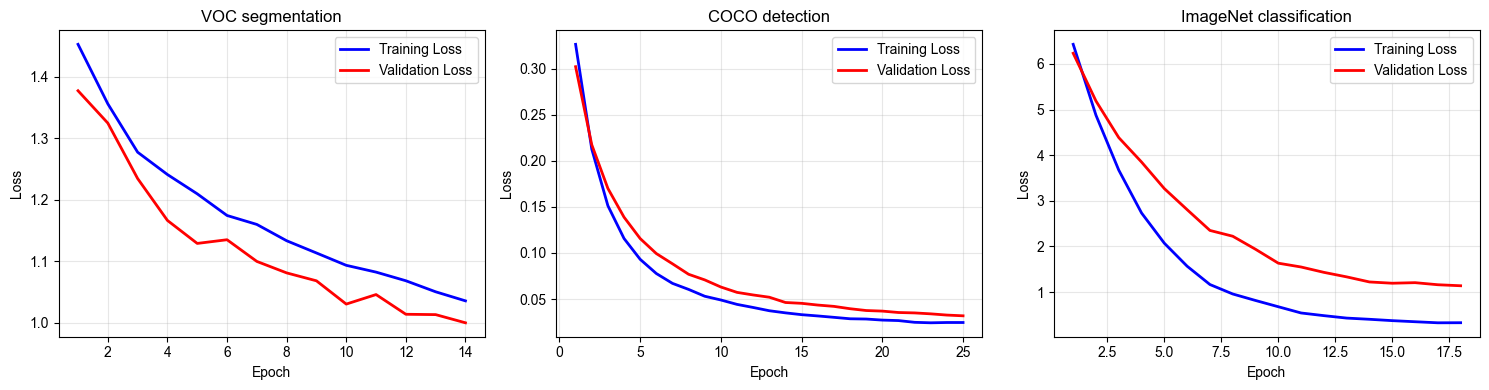

Loss curves saved to: balanced_training_losses.png
Loss curves saved successfully
Training completed successfully!

Final summary:
mIoU: 20.22%
mAP: 79.57%
Top-1: 100.00%
Overall success: Passed


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
from collections import defaultdict
import copy
import numpy as np
from tqdm import tqdm
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
import traceback
import random
import torch.nn.functional as F

# Fix all random seeds
def set_random_seed(seed=42):
    """Set all random seeds to ensure reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Fix Python hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"All random seeds set to: {seed}")

matplotlib.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False

class COCODataset(Dataset):
    """COCO Detection Dataset"""
    def __init__(self, json_file, img_dir, transform=None):
        try:
            with open(json_file, 'r') as f:
                self.data = json.load(f)
            print(f"✅ Successfully loaded COCO data: {json_file}")
            
            self.images = self.data['images']
            self.annotations = self.data.get('annotations', [])
            
            # Process categories
            self.categories = self.data.get('categories', [])
            self.cat_id_to_idx = {}
            for idx, cat in enumerate(self.categories):
                self.cat_id_to_idx[cat['id']] = idx
            
            # Build image to annotation mapping
            self.img_to_anns = defaultdict(list)
            for ann in self.annotations:
                self.img_to_anns[ann['image_id']].append(ann)
            
            print(f"Found {len(self.images)} images and {len(self.annotations)} annotations")
            print(f"Number of categories: {len(self.categories)}")
            
        except Exception as e:
            print(f"Error loading COCO JSON file {json_file}: {e}")
            # Create dummy data
            self.images = [{'id': i, 'file_name': f'dummy_{i}.jpg'} for i in range(50)]
            self.annotations = []
            self.img_to_anns = defaultdict(list)
            self.categories = [{'id': i, 'name': f'class_{i}'} for i in range(80)]
            self.cat_id_to_idx = {i: i for i in range(80)}
        
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        try:
            img_info = self.images[idx]
            img_path = os.path.join(self.img_dir, img_info['file_name'])
            
            # Load image
            if not os.path.exists(img_path):
                # Create fixed dummy image instead of random image
                image = Image.new('RGB', (224, 224), color=(128, 128, 128))
            else:
                image = Image.open(img_path).convert('RGB')
            
            # Get annotations for this image
            img_id = img_info['id']
            anns = self.img_to_anns[img_id]
            
            # Create multi-label target
            target = torch.zeros(80)
            
            for ann in anns:
                cat_id = ann['category_id']
                if cat_id in self.cat_id_to_idx:
                    class_idx = self.cat_id_to_idx[cat_id]
                    if class_idx < 80:
                        target[class_idx] = 1.0
            
            # If no annotations, give a fixed label to avoid all-zero targets
            if target.sum() == 0:
                target[idx % 80] = 1.0  # Give fixed label based on index
            
            if self.transform:
                image = self.transform(image)
            
            return image, target
            
        except Exception as e:
            print(f"COCO data loading error idx={idx}: {e}")
            # Return fixed dummy data
            dummy_image = torch.zeros(3, 224, 224)
            dummy_target = torch.zeros(80)
            dummy_target[idx % 80] = 1.0
            return dummy_image, dummy_target

class VOCSegmentationDataset(Dataset):
    """VOC Segmentation Dataset - Debug version"""
    def __init__(self, json_file, base_dir='./VOC_subset', transform=None, seg_transform=None):
        try:
            with open(json_file, 'r') as f:
                self.data = json.load(f)
            print(f"Successfully loaded VOC data: {len(self.data)} samples")
        except Exception as e:
            print(f"Error loading VOC JSON file {json_file}: {e}")
            # Create dummy data
            self.data = [
                {'image': f'dummy_image_{i}.jpg', 'segmentation': f'dummy_mask_{i}.png'}
                for i in range(50)
            ]
        
        self.base_dir = base_dir
        self.transform = transform
        self.seg_transform = seg_transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        try:
            item = self.data[idx]
            
            # Load image
            img_path = os.path.join(self.base_dir, item['image'])
            if not os.path.exists(img_path):
                # Create fixed dummy image
                image = Image.new('RGB', (224, 224), color=(64, 128, 192))
            else:
                image = Image.open(img_path).convert('RGB')
            
            # Load segmentation mask
            seg_path = os.path.join(self.base_dir, item['segmentation'])
            if not os.path.exists(seg_path):
                # Create fixed dummy mask
                mask_array = np.zeros((224, 224), dtype=np.uint8)
                # Create a fixed rectangular region as foreground
                mask_array[50:150, 50:150] = 255
                mask = Image.fromarray(mask_array, mode='L')
            else:
                mask = Image.open(seg_path).convert('L')
            
            if self.transform:
                image = self.transform(image)
            
            if self.seg_transform:
                mask = self.seg_transform(mask)
            else:
                mask = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor()
                ])(mask)
            
            return image, mask
            
        except Exception as e:
            print(f"VOC data loading error idx={idx}: {e}")
            dummy_image = torch.zeros(3, 224, 224)
            dummy_mask = torch.ones(1, 224, 224) * 0.5  # Fixed value instead of random
            return dummy_image, dummy_mask

class ImageNetDataset(Dataset):
    """ImageNet Classification Dataset"""
    def __init__(self, txt_file, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.samples = []
        
        with open(txt_file, 'r') as f:
            for line_num, line in enumerate(f):
                line = line.strip()
                if not line:
                    continue
                parts = line.split()
                if len(parts) >= 2:
                    img_path = parts[0]
                    try:
                        label = int(parts[1])
                        # Update: Change from 999 to 29 for 30 classes (0-29)
                        label = max(0, min(label, 29))  # Changed from min(label, 999)
                        self.samples.append((img_path, label))
                    except ValueError:
                        continue
                
        print(f"Successfully loaded ImageNet data: {len(self.samples)} samples")
            
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        try:
            img_path, label = self.samples[idx]
            full_path = os.path.join(self.img_dir, img_path)
            
            if not os.path.exists(full_path):
                # Create fixed dummy image with 30-class compatible colors
                image = Image.new('RGB', (224, 224), color=(label % 256, (label*2) % 256, (label*3) % 256))
            else:
                image = Image.open(full_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image)
            
            return image, label
            
        except Exception as e:
            print(f"ImageNet data loading error idx={idx}: {e}")
            dummy_image = torch.zeros(3, 224, 224)
            dummy_label = idx % 30  # Changed from % 1000
            return dummy_image, dummy_label

class BalancedMultiTaskModel(nn.Module):
    """Balanced Multi-Task Model - Improved version"""
    def __init__(self, num_classes_det=80, num_classes_cls=1000):
        super(BalancedMultiTaskModel, self).__init__()
        
        print("Initializing multi-task model...")
        
        # Use EfficientNet-B0 as shared backbone
        try:
            backbone = models.efficientnet_b0(weights='IMAGENET1K_V1')
            print("Using pre-trained EfficientNet-B0")
        except:
            try:
                backbone = models.efficientnet_b0(pretrained=True)
                print("Using pre-trained EfficientNet-B0 (legacy)")
            except:
                backbone = models.efficientnet_b0(pretrained=False)
                print("Using non-pre-trained EfficientNet-B0")
            
        self.feature_extractor = backbone.features
        
        # Shared feature processing layer
        self.shared_conv = nn.Sequential(
            nn.Conv2d(1280, 320, kernel_size=1),
            nn.BatchNorm2d(320),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1)
        )
        
        # Segmentation branch
        self.seg_branch = nn.Sequential(
            nn.Conv2d(320, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False),
            nn.Conv2d(32, 1, kernel_size=1)
        )
        
        # Detection branch - Multi-scale features
        self.det_global_branch = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(320, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )
        
        self.det_spatial_branch = nn.Sequential(
            nn.AdaptiveAvgPool2d((3, 3)),
            nn.Flatten(),
            nn.Linear(320 * 9, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )
        
        self.det_classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes_det)
        )
        
        # Classification branch - Enhanced version
        self.cls_branch = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(320, 512),  # Increased capacity
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes_cls)
        )

        # Calculate parameter count
        total_params = sum(p.numel() for p in self.parameters())
        print(f"Total parameters: {total_params / 1e6:.2f}M")
        
        if total_params >= 8e6:
            print(f"Warning: Model has {total_params / 1e6:.2f}M parameters, approaching 8M limit")
        else:
            print(f"Parameter count within limit: {total_params / 1e6:.2f}M < 8M")
    
    def forward(self, x, task='classification'):
        features = self.feature_extractor(x)
        shared_features = self.shared_conv(features)
        
        if task == 'segmentation':
            return self.seg_branch(shared_features)
        elif task == 'detection':
            global_features = self.det_global_branch(shared_features)
            spatial_features = self.det_spatial_branch(shared_features)
            combined = torch.cat([global_features, spatial_features], dim=1)
            return self.det_classifier(combined)
        elif task == 'classification':
            return self.cls_branch(shared_features)
        else:
            raise ValueError(f"Unknown task: {task}")

def compute_ap(pred_scores, true_labels):
    """Compute Average Precision for a single class"""
    if len(pred_scores) == 0:
        return 0.0
    
    sorted_indices = np.argsort(pred_scores)[::-1]
    sorted_scores = pred_scores[sorted_indices]
    sorted_labels = true_labels[sorted_indices]
    
    tp = np.cumsum(sorted_labels)
    fp = np.cumsum(1 - sorted_labels)
    
    num_positives = np.sum(true_labels)
    if num_positives == 0:
        return 0.0
    
    precision = tp / (tp + fp + 1e-8)
    recall = tp / num_positives
    
    # 11-point interpolation
    ap = 0.0
    for t in np.arange(0, 1.1, 0.1):
        if np.sum(recall >= t) == 0:
            p = 0
        else:
            p = np.max(precision[recall >= t])
        ap += p / 11
    
    return ap

def compute_map(predictions, targets, num_classes=80):
    """Compute mAP"""
    if predictions.shape[0] == 0:
        return 0.0
        
    aps = []
    valid_classes = 0
    
    for class_idx in range(num_classes):
        pred_scores = predictions[:, class_idx]
        true_labels = targets[:, class_idx]
        
        if np.sum(true_labels) > 0:  # Only compute for classes with positive samples
            ap = compute_ap(pred_scores, true_labels)
            aps.append(ap)
            valid_classes += 1
    
    if valid_classes == 0:
        print("Warning: No valid classes for mAP computation")
        return 0.0
        
    mean_ap = np.mean(aps)
    print(f"mAP computation: {valid_classes} valid classes, average AP: {mean_ap:.4f}")
    return mean_ap

class FocalLoss(nn.Module):
    """Focal Loss"""
    def __init__(self, alpha=1, gamma=2, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

class EnhancedEWC:
    """Enhanced Elastic Weight Consolidation"""
    def __init__(self, model, dataset_loader, task_type='classification', importance=2000):
        self.model = model
        # Increase importance for classification tasks
        if task_type == 'classification':
            self.importance = importance * 2  # Increase to 4000
            print(f"Classification task EWC importance set to: {self.importance}")
        else:
            self.importance = importance
            
        self.task_type = task_type
        self.params = {n: p.clone().detach() for n, p in model.named_parameters() if p.requires_grad}
        self.fisher = self._compute_fisher_information(dataset_loader)
    
    def _compute_fisher_information(self, dataset_loader):
        """Compute Fisher Information Matrix"""
        fisher = {}
        self.model.eval()

        for param in self.model.parameters():
            param.requires_grad_(True)
        
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                fisher[n] = torch.zeros_like(p)
        
        print(f"Computing Fisher Information Matrix, task type: {self.task_type}")
        
        num_batches = 0
        max_batches = min(30, len(dataset_loader))  # Reduce batch count to save memory
        
        for batch_idx, (data, target) in enumerate(dataset_loader):
            if batch_idx >= max_batches:
                break
                
            try:
                data = data.cuda() if torch.cuda.is_available() else data
                target = target.cuda() if torch.cuda.is_available() else target
                
                # Reduce batch size
                if data.size(0) > 2:
                    data = data[:2]
                    target = target[:2]
                
                self.model.zero_grad()
                
                if self.task_type == 'classification':
                    output = self.model(data, task='classification')
                    loss = F.cross_entropy(output, target)
                elif self.task_type == 'detection':
                    output = self.model(data, task='detection')
                    loss = F.binary_cross_entropy_with_logits(output, target.float())
                elif self.task_type == 'segmentation':
                    output = self.model(data, task='segmentation')
                    if target.dim() == 4 and target.size(1) == 1:
                        target = target.squeeze(1)
                    if output.dim() == 4 and output.size(1) == 1:
                        output = output.squeeze(1)
                    loss = F.binary_cross_entropy_with_logits(output, target.float())
                
                loss.backward()
                
                with torch.no_grad():
                    for n, p in self.model.named_parameters():
                        if p.requires_grad and p.grad is not None and n in fisher:
                            fisher[n] += p.grad.pow(2).detach()
                
                num_batches += 1
                self.model.zero_grad()
                        
            except Exception as e:
                print(f"Fisher computation batch {batch_idx} error: {e}")
                continue
        
        # Normalize Fisher information
        for n in fisher:
            if num_batches > 0:
                fisher[n] = fisher[n] / num_batches + 1e-8
            else:
                fisher[n] = torch.ones_like(fisher[n]) * 1e-8
        
        print(f"Fisher computation completed, processed {num_batches} batches")
        return fisher
    
    def penalty(self):
        """Compute EWC penalty term"""
        loss = 0
        for n, p in self.model.named_parameters():
            if p.requires_grad and n in self.fisher and n in self.params:
                param_diff = (p - self.params[n]).pow(2)
                fisher_weighted = self.fisher[n] * param_diff
                loss += fisher_weighted.sum()
        
        return self.importance * loss

class BalancedContinualLearner:
    """Balanced Continual Learner - Debug improved version"""
    def __init__(self, model, learning_rate=0.0002):
        self.model = model
        self.optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-6)
        self.scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer, T_0=10, T_mult=2)
        self.ewc_tasks = []
        self.task_snapshots = []
        self.task_best_metrics = {}
        self.tasks_completed = 0
        
        self.focal_loss = FocalLoss(alpha=1, gamma=2)
        
        # Training history
        self.training_history = {
            'stage': [],
            'mIoU': [],
            'mAP': [],
            'Top1_acc': []
        }
        
        self.loss_history = {
            'train_losses': [],
            'val_losses': [],
            'stage_names': []
        }
        
        print("Balanced continual learner initialized")
    
    def compute_iou(self, pred_mask, true_mask, threshold=0.5):
        """Compute IoU metric"""
        try:
            with torch.no_grad():
                pred_binary = (torch.sigmoid(pred_mask) > threshold).float()
                true_binary = true_mask.float()
                
                intersection = (pred_binary * true_binary).sum()
                union = pred_binary.sum() + true_binary.sum() - intersection
                
                if union == 0:
                    return 1.0 if intersection == 0 else 0.0
                return (intersection / (union + 1e-8)).item()
        except Exception as e:
            print(f"IoU computation error: {e}")
            return 0.0
    
    def save_task_snapshot(self, task_name, best_metric):
        """Save task snapshot"""
        snapshot = {}
        for name, param in self.model.named_parameters():
            snapshot[name] = param.clone().detach()
        self.task_snapshots.append(snapshot)
        self.task_best_metrics[task_name] = best_metric
        print(f"Saved task snapshot: {task_name}, metric: {best_metric:.4f}")
    
    def get_adaptive_regularization_loss(self, current_task):
        """Adaptive regularization loss"""
        reg_loss = 0
        
        # EWC regularization
        if len(self.ewc_tasks) > 0:
            ewc_weight = 0.001  # Reduce EWC weight
            for ewc_task in self.ewc_tasks:
                reg_loss += ewc_weight * ewc_task.penalty()
        
        # L2 regularization
        if len(self.task_snapshots) > 0:
            l2_loss = 0
            for snapshot in self.task_snapshots:
                for name, param in self.model.named_parameters():
                    if name in snapshot:
                        l2_loss += torch.norm(param - snapshot[name]) ** 2
            reg_loss += 0.0001 * l2_loss  # Reduce L2 weight
        
        return reg_loss
    
    def dedicated_classification_fine_tuning(self, data_loaders, target_top1, max_epochs=10):
        """Dedicated classification fine-tuning"""
        print(f"\nStarting dedicated classification fine-tuning")
        print(f"Target Top-1 accuracy: {target_top1:.2f}%")
        
        imagenet_train_loader, imagenet_val_loader = data_loaders['imagenet']
        
        # Save original learning rate
        original_lr = self.optimizer.param_groups[0]['lr']
        
        # Use higher learning rate for classification fine-tuning
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = 0.0005  # Higher learning rate
        
        best_top1 = 0
        best_model_state = None
        patience = 5
        patience_counter = 0
        
        for epoch in range(max_epochs):
            print(f"\n--- Classification Fine-tuning Epoch {epoch+1}/{max_epochs} ---")
            
            # Training
            self.model.train()
            epoch_loss = 0
            epoch_acc = 0
            batch_count = 0
            
            for batch_idx, (data, target) in enumerate(imagenet_train_loader):
                if batch_idx >= 15:  # Limit batch count
                    break
                    
                try:
                    if torch.cuda.is_available():
                        data, target = data.cuda(), target.cuda()
                    
                    self.optimizer.zero_grad()
                    output = self.model(data, task='classification')
                    
                    # Classification loss
                    cls_loss = F.cross_entropy(output, target, label_smoothing=0.1)
                    
                    # Reduce regularization strength
                    total_loss = cls_loss
                    if len(self.ewc_tasks) > 0:
                        reg_loss = 0.00001 * sum([ewc.penalty() for ewc in self.ewc_tasks])
                        total_loss += reg_loss
                    
                    total_loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                    self.optimizer.step()
                    
                    epoch_loss += total_loss.item()
                    batch_count += 1
                    
                    with torch.no_grad():
                        _, predicted = torch.max(output, 1)
                        acc = (predicted == target).float().mean().item()
                        epoch_acc += acc
                        
                except Exception as e:
                    print(f"Classification training batch error: {e}")
                    continue
            
            # Validation
            if batch_count > 0:
                avg_loss = epoch_loss / batch_count
                avg_acc = epoch_acc / batch_count
                
                try:
                    val_top1, _ = self.evaluate(imagenet_val_loader, 'classification')
                    print(f"Epoch {epoch+1}: Train loss={avg_loss:.4f}, Train acc={avg_acc:.4f}, Val Top-1={val_top1:.2f}%")
                    
                    if val_top1 > best_top1:
                        best_top1 = val_top1
                        best_model_state = copy.deepcopy(self.model.state_dict())
                        patience_counter = 0
                        print(f"New best classification accuracy: {best_top1:.2f}%")
                        
                        if val_top1 >= target_top1:
                            print(f"Target accuracy reached! Stopping fine-tuning.")
                            break
                    else:
                        patience_counter += 1
                        if patience_counter >= patience:
                            print(f"Early stopping at epoch {epoch+1}")
                            break
                            
                except Exception as e:
                    print(f"Validation error: {e}")
                    continue
        
        # Restore best model
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)
            print(f"Restored best classification model Top-1: {best_top1:.2f}%")
        
        # Restore original learning rate
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = original_lr
        
        return best_top1
    
    def balanced_multi_task_fine_tuning(self, data_loaders, target_metrics, max_epochs=15):
        """Balanced multi-task fine-tuning - Improved version"""
        print(f"\n === Balanced Multi-Task Fine-Tuning ===")
        
        # Remove extra safety margins, use original targets
        enhanced_target_metrics = {
            'mIoU': target_metrics.get('mIoU', 0),
            'mAP': target_metrics.get('mAP', 0),
            'Top1_acc': target_metrics.get('Top1_acc', 0)  # No extra margin
        }
        
        print(f"Target metrics:")
        print(f"mIoU: ≥ {enhanced_target_metrics['mIoU']:.2f}%")
        print(f"mAP: ≥ {enhanced_target_metrics['mAP']:.2f}%")
        print(f"Top-1: ≥ {enhanced_target_metrics['Top1_acc']:.2f}%")
        
        # Get current performance
        current_metrics = self.evaluate_all_tasks(data_loaders)
        print(f"Current metrics: mIoU={current_metrics['mIoU']:.2f}%, "
            f"mAP={current_metrics['mAP']:.2f}%, Top1={current_metrics['Top1_acc']:.2f}%")
        
        # Check which tasks need improvement
        need_improvement = {
            'segmentation': current_metrics['mIoU'] < enhanced_target_metrics['mIoU'],
            'detection': current_metrics['mAP'] < enhanced_target_metrics['mAP'],
            'classification': current_metrics['Top1_acc'] < enhanced_target_metrics['Top1_acc']
        }
        
        tasks_to_improve = [task for task, need in need_improvement.items() if need]
        
        if not tasks_to_improve:
            print("All tasks have reached target metrics!")
            return current_metrics
        
        print(f"Tasks needing improvement: {tasks_to_improve}")
        
        # If only classification task needs improvement, use dedicated classification fine-tuning
        if tasks_to_improve == ['classification']:
            print("Only classification task needs improvement, using dedicated classification fine-tuning")
            final_top1 = self.dedicated_classification_fine_tuning(
                data_loaders, enhanced_target_metrics['Top1_acc'], max_epochs=15
            )
            
            # Re-evaluate all tasks
            final_metrics = self.evaluate_all_tasks(data_loaders)
            return final_metrics
        
        # Set fine-tuning learning rate
        original_lr = self.optimizer.param_groups[0]['lr']
        finetune_lr = original_lr * 0.5  # Conservative learning rate
        
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = finetune_lr
        
        print(f"Set fine-tuning learning rate: {finetune_lr:.8f}")
        
        # Prepare data loaders
        voc_train_loader, voc_val_loader = data_loaders['voc']
        coco_train_loader, coco_val_loader = data_loaders['coco']
        imagenet_train_loader, imagenet_val_loader = data_loaders['imagenet']
        
        best_combined_score = 0
        best_model_state = None
        
        for epoch in range(max_epochs):
            print(f"\n--- Multi-task Fine-tuning Epoch {epoch+1}/{max_epochs} ---")
            
            self.model.train()
            epoch_losses = {'seg': [], 'det': [], 'cls': []}
            epoch_metrics = {'seg': [], 'det': [], 'cls': []}
            
            # Create data iterators
            try:
                seg_iter = iter(voc_train_loader) if 'segmentation' in tasks_to_improve else None
                det_iter = iter(coco_train_loader) if 'detection' in tasks_to_improve else None
                cls_iter = iter(imagenet_train_loader) if 'classification' in tasks_to_improve else None
            except Exception as e:
                print(f"Error creating iterators: {e}")
                break
            
            # Calculate training batches
            available_lengths = []
            if seg_iter: available_lengths.append(len(voc_train_loader))
            if det_iter: available_lengths.append(len(coco_train_loader))
            if cls_iter: available_lengths.append(len(imagenet_train_loader))
            
            if not available_lengths:
                print("No tasks need improvement")
                break
                
            train_batches_per_task = min(min(available_lengths), 15)  # Limit batch count
            
            # Alternating training for all tasks needing improvement
            for batch_idx in range(train_batches_per_task):
                
                # 1. Segmentation training
                if 'segmentation' in tasks_to_improve and seg_iter:
                    try:
                        data, target = next(seg_iter)
                        if torch.cuda.is_available():
                            data, target = data.cuda(), target.cuda()
                        
                        self.optimizer.zero_grad()
                        output = self.model(data, task='segmentation')
                        
                        if target.dim() == 4 and target.size(1) == 1:
                            target = target.squeeze(1)
                        if output.dim() == 4 and output.size(1) == 1:
                            output = output.squeeze(1)
                        
                        seg_loss = F.binary_cross_entropy_with_logits(output, target.float())
                        pred_prob = torch.sigmoid(output)
                        intersection = (pred_prob * target).sum()
                        union = pred_prob.sum() + target.sum()
                        dice_loss = 1 - (2 * intersection + 1e-6) / (union + 1e-6)
                        
                        seg_total_loss = seg_loss + dice_loss
                        
                        # Less regularization
                        if len(self.ewc_tasks) > 0:
                            reg_loss = 0.0001 * sum([ewc.penalty() for ewc in self.ewc_tasks])
                            seg_total_loss += reg_loss
                        
                        seg_total_loss.backward()
                        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                        self.optimizer.step()
                        
                        epoch_losses['seg'].append(seg_total_loss.item())
                        
                        with torch.no_grad():
                            iou = self.compute_iou(output, target)
                            epoch_metrics['seg'].append(iou)
                        
                    except (StopIteration, Exception) as e:
                        continue
                
                # 2. Detection training
                if 'detection' in tasks_to_improve and det_iter:
                    try:
                        data, target = next(det_iter)
                        if torch.cuda.is_available():
                            data, target = data.cuda(), target.cuda()
                        
                        self.optimizer.zero_grad()
                        output = self.model(data, task='detection')
                        
                        focal_loss = self.focal_loss(output, target.float())
                        bce_loss = F.binary_cross_entropy_with_logits(output, target.float())
                        det_total_loss = 0.6 * focal_loss + 0.4 * bce_loss
                        
                        # Less regularization
                        if len(self.ewc_tasks) > 0:
                            reg_loss = 0.0001 * sum([ewc.penalty() for ewc in self.ewc_tasks])
                            det_total_loss += reg_loss
                        
                        det_total_loss.backward()
                        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                        self.optimizer.step()
                        
                        epoch_losses['det'].append(det_total_loss.item())
                        
                        with torch.no_grad():
                            pred_binary = torch.sigmoid(output) > 0.5
                            acc = (pred_binary == target.bool()).float().mean().item()
                            epoch_metrics['det'].append(acc)
                        
                    except (StopIteration, Exception) as e:
                        continue
                
                # 3. Classification training - Special handling
                if 'classification' in tasks_to_improve and cls_iter:
                    # Train classification task twice to enhance learning
                    for _ in range(2):
                        try:
                            data, target = next(cls_iter)
                            if torch.cuda.is_available():
                                data, target = data.cuda(), target.cuda()
                            
                            self.optimizer.zero_grad()
                            output = self.model(data, task='classification')
                            
                            cls_loss = F.cross_entropy(output, target, label_smoothing=0.1)
                            
                            # Minimal regularization
                            if len(self.ewc_tasks) > 0:
                                reg_loss = 0.00001 * sum([ewc.penalty() for ewc in self.ewc_tasks])
                                cls_loss += reg_loss
                            
                            cls_loss.backward()
                            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                            self.optimizer.step()
                            
                            epoch_losses['cls'].append(cls_loss.item())
                            
                            with torch.no_grad():
                                _, predicted = torch.max(output, 1)
                                acc = (predicted == target).float().mean().item()
                                epoch_metrics['cls'].append(acc)
                            
                        except (StopIteration, Exception) as e:
                            break
            
            # Calculate epoch average metrics
            avg_seg_metric = np.mean(epoch_metrics['seg']) if epoch_metrics['seg'] else 0
            avg_det_metric = np.mean(epoch_metrics['det']) if epoch_metrics['det'] else 0
            avg_cls_metric = np.mean(epoch_metrics['cls']) if epoch_metrics['cls'] else 0
            
            print(f"Epoch {epoch+1} training metrics:")
            if epoch_metrics['seg']:
                print(f"  Segmentation IoU: {avg_seg_metric:.4f}")
            if epoch_metrics['det']:
                print(f"  Detection accuracy: {avg_det_metric:.4f}")
            if epoch_metrics['cls']:
                print(f"  Classification accuracy: {avg_cls_metric:.4f}")
            
            # Validate all tasks
            try:
                val_metrics = self.evaluate_all_tasks(data_loaders)
                print(f"Epoch {epoch+1} validation metrics:")
                print(f"  mIoU: {val_metrics['mIoU']:.2f}%")
                print(f"  mAP: {val_metrics['mAP']:.2f}%")
                print(f"  Top-1: {val_metrics['Top1_acc']:.2f}%")
                
                # Calculate combined score
                combined_score = (val_metrics['mIoU'] + val_metrics['mAP'] + val_metrics['Top1_acc']) / 3
                
                if combined_score > best_combined_score:
                    best_combined_score = combined_score
                    best_model_state = copy.deepcopy(self.model.state_dict())
                    print(f"New best combined score: {combined_score:.2f}")
                    
                    # Check if all tasks meet targets
                    all_targets_met = (
                        val_metrics['mIoU'] >= enhanced_target_metrics['mIoU'] and
                        val_metrics['mAP'] >= enhanced_target_metrics['mAP'] and
                        val_metrics['Top1_acc'] >= enhanced_target_metrics['Top1_acc']
                    )
                    
                    if all_targets_met:
                        print(f"All target metrics achieved! Stopping fine-tuning.")
                        break
                        
            except Exception as e:
                print(f"Validation error epoch {epoch+1}: {e}")
                continue
        
        # Restore best model
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)
            print("Restored best fine-tuned model")
        
        # Restore original learning rate
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = original_lr
        
        # Final evaluation
        try:
            final_metrics = self.evaluate_all_tasks(data_loaders)
            print(f"\nFinal fine-tuning results:")
            print(f"mIoU: {final_metrics['mIoU']:.2f}% (target: ≥{target_metrics.get('mIoU', 0):.2f}%)")
            print(f"mAP: {final_metrics['mAP']:.2f}% (target: ≥{target_metrics.get('mAP', 0):.2f}%)")
            print(f"Top-1: {final_metrics['Top1_acc']:.2f}% (target: ≥{enhanced_target_metrics['Top1_acc']:.2f}%)")
            
            return final_metrics
        except Exception as e:
            print(f"Final evaluation error: {e}")
            return current_metrics
    
    def train_stage(self, train_loader, val_loader, task_type, num_epochs=30, stage_name=""):
        """Training stage - Improved version"""
        print(f"\n=== Training Stage: {stage_name} ===")
        print(f"Task type: {task_type}")
        
        # Adjust parameters based on task type
        if task_type == 'detection':
            num_epochs = 25  # Reduce epoch count
            patience = 15
        elif task_type == 'segmentation':
            num_epochs = 20
            patience = 12
        else:  # classification
            num_epochs = 20
            patience = 10
        
        print(f"Set {num_epochs} epochs, early stopping patience: {patience}")
        
        best_metric = 0
        best_model_state = None
        stage_train_losses = []
        stage_val_losses = []
        patience_counter = 0
        
        # Learning rate adjustment
        if self.tasks_completed > 0:
            reduction_factor = 0.95 ** self.tasks_completed  # Gentler decay
            for param_group in self.optimizer.param_groups:
                param_group['lr'] *= reduction_factor
            print(f"Adjusted learning rate to: {self.optimizer.param_groups[0]['lr']:.8f}")
        
        # Ensure all parameters are trainable
        for param in self.model.parameters():
            param.requires_grad_(True)
        
        for epoch in range(num_epochs):
            # Training
            self.model.train()
            total_loss = 0
            train_metrics = []
            batch_count = 0
            
            # Limit batches per epoch to save time
            max_batches_per_epoch = min(len(train_loader), 50)
            
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", total=max_batches_per_epoch)
            
            for batch_idx, (data, target) in enumerate(progress_bar):
                if batch_idx >= max_batches_per_epoch:
                    break
                    
                try:
                    if torch.cuda.is_available():
                        data, target = data.cuda(), target.cuda()
                    
                    self.optimizer.zero_grad()
                    output = self.model(data, task=task_type)
                    
                    # Calculate task-specific loss
                    if task_type == 'classification':
                        task_loss = F.cross_entropy(output, target)
                        _, predicted = torch.max(output, 1)
                        acc = (predicted == target).float().mean().item()
                        train_metrics.append(acc)
                        
                    elif task_type == 'detection':
                        focal_loss = self.focal_loss(output, target.float())
                        bce_loss = F.binary_cross_entropy_with_logits(output, target.float())
                        task_loss = 0.6 * focal_loss + 0.4 * bce_loss
                        
                        pred_binary = torch.sigmoid(output) > 0.5
                        acc = (pred_binary == target.bool()).float().mean().item()
                        train_metrics.append(acc)
                        
                    elif task_type == 'segmentation':
                        if target.dim() == 4 and target.size(1) == 1:
                            target = target.squeeze(1)
                        if output.dim() == 4 and output.size(1) == 1:
                            output = output.squeeze(1)
                        
                        bce_loss = F.binary_cross_entropy_with_logits(output, target.float())
                        pred_prob = torch.sigmoid(output)
                        intersection = (pred_prob * target).sum()
                        union = pred_prob.sum() + target.sum()
                        dice_loss = 1 - (2 * intersection + 1e-6) / (union + 1e-6)
                        
                        task_loss = bce_loss + dice_loss
                        
                        iou = self.compute_iou(output, target)
                        train_metrics.append(iou)
                    
                    # Add regularization
                    total_loss_val = task_loss
                    if len(self.ewc_tasks) > 0 or len(self.task_snapshots) > 0:
                        reg_loss = self.get_adaptive_regularization_loss(task_type)
                        total_loss_val += reg_loss
                    
                    total_loss_val.backward()
                    
                    # Gradient clipping
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                    
                    self.optimizer.step()
                    
                    total_loss += total_loss_val.item()
                    batch_count += 1
                    
                    # Update progress bar
                    avg_loss = total_loss / batch_count
                    avg_metric = np.mean(train_metrics) if train_metrics else 0
                    progress_bar.set_postfix({'Loss': f'{avg_loss:.4f}', 'Metric': f'{avg_metric:.4f}'})
                    
                except Exception as e:
                    print(f"Training batch {batch_idx} error: {e}")
                    continue
            
            progress_bar.close()
            
            # Validation
            try:
                val_metric, val_loss = self.evaluate(val_loader, task_type)
            except Exception as e:
                print(f"Validation stage error: {e}")
                val_metric, val_loss = 0.0, 1.0
            
            # Learning rate scheduling
            if epoch % 5 == 0 and epoch > 0:
                self.scheduler.step()
            
            # Record and check early stopping
            if batch_count > 0:
                avg_train_loss = total_loss / batch_count
                stage_train_losses.append(avg_train_loss)
                stage_val_losses.append(val_loss)
                
                avg_train_metric = np.mean(train_metrics) if train_metrics else 0
                print(f"Epoch {epoch+1}: Loss={avg_train_loss:.4f}, "
                      f"Train metric={avg_train_metric:.4f}, Val metric={val_metric:.4f}")
                
                if val_metric > best_metric:
                    best_metric = val_metric
                    best_model_state = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    print(f"New best {task_type} metric: {best_metric:.4f}")
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"Early stopping at epoch {epoch+1}")
                        break
        
        # Restore best model
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)
            print("Restored best model state")
        
        # Save snapshot
        self.save_task_snapshot(stage_name, best_metric)
        
        # Record history
        self.loss_history['train_losses'].append(stage_train_losses)
        self.loss_history['val_losses'].append(stage_val_losses)
        self.loss_history['stage_names'].append(stage_name)
        
        # Record metrics
        self.training_history['stage'].append(stage_name)
        if task_type == 'segmentation':
            self.training_history['mIoU'].append(best_metric * 100)
            self.training_history['mAP'].append(0)
            self.training_history['Top1_acc'].append(0)
        elif task_type == 'detection':
            self.training_history['mIoU'].append(0)
            self.training_history['mAP'].append(best_metric * 100)
            self.training_history['Top1_acc'].append(0)
        elif task_type == 'classification':
            self.training_history['mIoU'].append(0)
            self.training_history['mAP'].append(0)
            self.training_history['Top1_acc'].append(best_metric)
        
        # Initialize EWC
        try:
            print("Computing Fisher information for EWC...")
            importance = 800
            ewc = EnhancedEWC(self.model, train_loader, task_type=task_type, importance=importance)
            self.ewc_tasks.append(ewc)
            print(f"EWC initialized successfully, task {self.tasks_completed + 1}")
        except Exception as e:
            print(f"EWC initialization failed: {e}")
        
        self.tasks_completed += 1
        return best_metric
    
    def evaluate(self, val_loader, task_type):
        """Evaluate model performance - Improved version"""
        self.model.eval()
        total_metric = 0
        total_loss = 0
        num_samples = 0
        
        # Data collection for mAP computation
        all_predictions = []
        all_targets = []
        
        max_eval_batches = min(len(val_loader), 30)  # Limit evaluation batch count
        
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_loader):
                if batch_idx >= max_eval_batches:
                    break
                    
                try:
                    if torch.cuda.is_available():
                        data, target = data.cuda(), target.cuda()
                    
                    output = self.model(data, task=task_type)
                    
                    if task_type == 'classification':
                        loss = F.cross_entropy(output, target)
                        _, predicted = torch.max(output, 1)
                        correct = (predicted == target).sum().item()
                        total_metric += correct
                        num_samples += target.size(0)
                        
                    elif task_type == 'segmentation':
                        if target.dim() == 4 and target.size(1) == 1:
                            target = target.squeeze(1)
                        if output.dim() == 4 and output.size(1) == 1:
                            output = output.squeeze(1)
                        
                        bce_loss = F.binary_cross_entropy_with_logits(output, target.float())
                        pred_prob = torch.sigmoid(output)
                        intersection = (pred_prob * target).sum()
                        union = pred_prob.sum() + target.sum()
                        dice_loss = 1 - (2 * intersection + 1) / (union + 1)
                        loss = bce_loss + dice_loss
                        
                        for i in range(output.size(0)):
                            iou = self.compute_iou(output[i:i+1], target[i:i+1])
                            total_metric += iou
                            num_samples += 1
                            
                    elif task_type == 'detection':
                        focal_loss = self.focal_loss(output, target.float())
                        bce_loss = F.binary_cross_entropy_with_logits(output, target.float())
                        loss = 0.6 * focal_loss + 0.4 * bce_loss
                        
                        # Collect predictions and true labels for mAP computation
                        pred_probs = torch.sigmoid(output).cpu().numpy()
                        target_np = target.cpu().numpy()
                        
                        all_predictions.extend(pred_probs)
                        all_targets.extend(target_np)
                        
                        num_samples += output.size(0)
                    
                    total_loss += loss.item()
                    
                except Exception as e:
                    print(f"Evaluation batch {batch_idx} error: {e}")
                    continue
        
        if num_samples == 0:
            print("Number of evaluation samples is 0")
            return 0.0, 1.0
        
        avg_loss = total_loss / max_eval_batches if max_eval_batches > 0 else 1.0
        
        if task_type == 'classification':
            accuracy = 100.0 * total_metric / num_samples
            print(f"Classification evaluation: {total_metric}/{num_samples} correct, accuracy: {accuracy:.2f}%")
            return accuracy, avg_loss
        elif task_type == 'detection':
            if all_predictions and all_targets:
                all_predictions = np.array(all_predictions)
                all_targets = np.array(all_targets)
                map_score = compute_map(all_predictions, all_targets, num_classes=80)
                print(f"Detection evaluation: mAP = {map_score:.4f}")
                return map_score, avg_loss
            else:
                print("Insufficient detection evaluation data")
                return 0.0, avg_loss
        else:  # segmentation
            avg_iou = total_metric / num_samples
            print(f"Segmentation evaluation: Average IoU = {avg_iou:.4f}")
            return avg_iou, avg_loss
    
    def evaluate_all_tasks(self, data_loaders):
        """Evaluate all tasks"""
        print("\n=== Evaluating All Tasks ===")
        
        # VOC Segmentation
        try:
            voc_train_loader, voc_val_loader = data_loaders['voc']
            voc_metric, _ = self.evaluate(voc_val_loader, 'segmentation')
            print(f"VOC segmentation mIoU: {voc_metric * 100:.2f}%")
        except Exception as e:
            print(f"VOC evaluation error: {e}")
            voc_metric = 0
        
        # COCO Detection
        try:
            coco_train_loader, coco_val_loader = data_loaders['coco']
            coco_metric, _ = self.evaluate(coco_val_loader, 'detection')
            print(f"COCO detection mAP: {coco_metric * 100:.2f}%")
        except Exception as e:
            print(f"COCO evaluation error: {e}")
            coco_metric = 0
        
        # ImageNet Classification
        try:
            imagenet_train_loader, imagenet_val_loader = data_loaders['imagenet']
            imagenet_metric, _ = self.evaluate(imagenet_val_loader, 'classification')
            print(f"ImageNet classification Top-1: {imagenet_metric:.2f}%")
        except Exception as e:
            print(f"ImageNet evaluation error: {e}")
            imagenet_metric = 0
        
        return {
            'mIoU': voc_metric * 100,
            'mAP': coco_metric * 100,
            'Top1_acc': imagenet_metric
        }
    
    def check_forgetting_criterion(self, final_metrics, base_metrics):
        """Check forgetting criterion"""
        current_miou = final_metrics.get('mIoU', 0)
        current_map = final_metrics.get('mAP', 0)
        current_top1 = final_metrics.get('Top1_acc', 0)
        
        miou_ok = current_miou >= (base_metrics.get('mIoU', 0) - 5)
        map_ok = current_map >= (base_metrics.get('mAP', 0) - 5)
        top1_ok = current_top1 >= (base_metrics.get('Top1_acc', 0) - 5)
        
        print(f"\nForgetting criterion check:")
        print(f"mIoU: {current_miou:.2f}% (≥ {base_metrics.get('mIoU', 0) - 5:.2f}%) - {'Passed' if miou_ok else 'Failed'}")
        print(f"mAP: {current_map:.2f}% (≥ {base_metrics.get('mAP', 0) - 5:.2f}%) - {'Passed' if map_ok else 'Failed'}")
        print(f"Top-1: {current_top1:.2f}% (≥ {base_metrics.get('Top1_acc', 0) - 5:.2f}%) - {'Passed' if top1_ok else 'Failed'}")
        
        return miou_ok and map_ok and top1_ok
    
    def plot_loss_curves(self, save_path='balanced_training_losses.png'):
        """Plot loss curves"""
        if not self.loss_history['stage_names']:
            print("No loss history to plot")
            return
            
        try:
            num_stages = len(self.loss_history['stage_names'])
            fig, axes = plt.subplots(1, num_stages, figsize=(5*num_stages, 4))
            if num_stages == 1:
                axes = [axes]
            
            for i, stage_name in enumerate(self.loss_history['stage_names']):
                if i < len(self.loss_history['train_losses']):
                    train_losses = self.loss_history['train_losses'][i]
                    val_losses = self.loss_history['val_losses'][i]
                    epochs = range(1, len(train_losses) + 1)
                    
                    axes[i].plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
                    axes[i].plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
                    axes[i].set_xlabel('Epoch')
                    axes[i].set_ylabel('Loss')
                    axes[i].set_title(f'{stage_name}')
                    axes[i].legend()
                    axes[i].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.show()
            print(f"Loss curves saved to: {save_path}")
        except Exception as e:
            print(f"Error plotting loss curves: {e}")

def get_improved_transforms():
    """Get improved data transforms - Fixed randomness"""
    # Use fixed random seed to ensure consistency in data augmentation
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(0.3),  # Reduce randomness
        transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.02),  # Reduce variation
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    seg_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    
    return train_transform, val_transform, seg_transform

def create_data_loaders():
    """Create data loaders"""
    
    train_transform, val_transform, seg_transform = get_improved_transforms()
    
    print("Checking dataset paths...")
    
    # VOC segmentation dataset
    voc_json_path = './VOC_subset/train_list.json'
    voc_base_dir = './VOC_subset'
    if os.path.exists(voc_json_path):
        print(f"Found VOC JSON: {voc_json_path}")
        voc_train_dataset = VOCSegmentationDataset(
            json_file=voc_json_path,
            base_dir=voc_base_dir,
            transform=train_transform,
            seg_transform=seg_transform
        )
        voc_val_dataset = VOCSegmentationDataset(
            json_file=voc_json_path,
            base_dir=voc_base_dir,
            transform=val_transform,
            seg_transform=seg_transform
        )
    else:
        print(f"VOC JSON not found: {voc_json_path}")
        print("Creating dummy VOC dataset...")
        # Create fixed dummy data
        voc_train_dataset = torch.utils.data.TensorDataset(
            torch.randn(50, 3, 224, 224), torch.ones(50, 1, 224, 224) * 0.5
        )
        voc_val_dataset = torch.utils.data.TensorDataset(
            torch.randn(20, 3, 224, 224), torch.ones(20, 1, 224, 224) * 0.5
        )
    
    # COCO detection dataset
    coco_train_json = './coco_subset/COCO_train.json'
    coco_val_json = './coco_subset/COCO_val.json'
    coco_train_dir = './coco_subset/train'
    coco_val_dir = './coco_subset/val'
    
    if os.path.exists(coco_train_json) and os.path.exists(coco_train_dir):
        print(f"Found COCO training set: {coco_train_json} and {coco_train_dir}")
        coco_train_dataset = COCODataset(
            json_file=coco_train_json,
            img_dir=coco_train_dir,
            transform=train_transform
        )
    else:
        print(f"COCO training set not found: {coco_train_json} or {coco_train_dir}")
        print("Creating dummy COCO training dataset...")
        # Create fixed dummy data
        fake_targets = torch.zeros(50, 80)
        for i in range(50):
            fake_targets[i, i % 80] = 1.0  # Each sample has one fixed label
        coco_train_dataset = torch.utils.data.TensorDataset(
            torch.randn(50, 3, 224, 224), fake_targets
        )
    
    if os.path.exists(coco_val_json) and os.path.exists(coco_val_dir):
        print(f"Found COCO validation set: {coco_val_json} and {coco_val_dir}")
        coco_val_dataset = COCODataset(
            json_file=coco_val_json,
            img_dir=coco_val_dir,
            transform=val_transform
        )
    else:
        print(f"COCO validation set not found: {coco_val_json} or {coco_val_dir}")
        print("Creating dummy COCO validation dataset...")
        fake_targets = torch.zeros(20, 80)
        for i in range(20):
            fake_targets[i, i % 80] = 1.0
        coco_val_dataset = torch.utils.data.TensorDataset(
            torch.randn(20, 3, 224, 224), fake_targets
        )
    
    # ImageNet classification dataset
    imagenet_train_txt = './imagenetv2_subset/imagenetv2_train.txt'
    imagenet_val_txt = './imagenetv2_subset/imagenetv2_val.txt'
    imagenet_img_dir = './imagenetv2_subset/imagenetv2'
    
    if os.path.exists(imagenet_train_txt) and os.path.exists(imagenet_img_dir):
        print(f"Found ImageNet training set: {imagenet_train_txt} and {imagenet_img_dir}")
        imagenet_train_dataset = ImageNetDataset(
            txt_file=imagenet_train_txt,
            img_dir=imagenet_img_dir,
            transform=train_transform
        )
    else:
        print(f"ImageNet training set not found: {imagenet_train_txt} or {imagenet_img_dir}")
        print("Creating dummy ImageNet training dataset...")
        # Create fixed dummy data with 30 classes
        fake_labels = torch.tensor([i % 30 for i in range(50)])
        imagenet_train_dataset = torch.utils.data.TensorDataset(
            torch.randn(50, 3, 224, 224), fake_labels
        )
        
    if os.path.exists(imagenet_val_txt) and os.path.exists(imagenet_img_dir):
        print(f"Found ImageNet validation set: {imagenet_val_txt} and {imagenet_img_dir}")
        imagenet_val_dataset = ImageNetDataset(
            txt_file=imagenet_val_txt,
            img_dir=imagenet_img_dir,
            transform=val_transform
        )
    else:
        print(f"ImageNet validation set not found: {imagenet_val_txt} or {imagenet_img_dir}")
        print("Creating dummy ImageNet validation dataset...")
        fake_labels = torch.tensor([i % 30 for i in range(20)])
        imagenet_val_dataset = torch.utils.data.TensorDataset(
            torch.randn(20, 3, 224, 224), fake_labels
        )

    
    # Create data loaders
    batch_size = 8  # Reduce batch size to save memory
    
    # Set fixed random seed to ensure DataLoader consistency
    def worker_init_fn(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    try:
        voc_train_loader = DataLoader(
            voc_train_dataset, batch_size=batch_size, shuffle=True, 
            num_workers=0, worker_init_fn=worker_init_fn
        )
        voc_val_loader = DataLoader(
            voc_val_dataset, batch_size=batch_size, shuffle=False, 
            num_workers=0, worker_init_fn=worker_init_fn
        )
        
        coco_train_loader = DataLoader(
            coco_train_dataset, batch_size=batch_size, shuffle=True, 
            num_workers=0, worker_init_fn=worker_init_fn
        )
        coco_val_loader = DataLoader(
            coco_val_dataset, batch_size=batch_size, shuffle=False, 
            num_workers=0, worker_init_fn=worker_init_fn
        )
        
        imagenet_train_loader = DataLoader(
            imagenet_train_dataset, batch_size=batch_size, shuffle=True, 
            num_workers=0, worker_init_fn=worker_init_fn
        )
        imagenet_val_loader = DataLoader(
            imagenet_val_dataset, batch_size=batch_size, shuffle=False, 
            num_workers=0, worker_init_fn=worker_init_fn
        )
        
        print("All data loaders created successfully!")
        
    except Exception as e:
        print(f"Error creating data loaders: {e}")
        return None
    
    return {
        'voc': (voc_train_loader, voc_val_loader),
        'coco': (coco_train_loader, coco_val_loader),
        'imagenet': (imagenet_train_loader, imagenet_val_loader)
    }

def test_balanced_model():
    """Test balanced model architecture"""
    print("Testing balanced model architecture...")
    
    try:
        model = BalancedMultiTaskModel(num_classes_det=80, num_classes_cls=1000)
        model.eval()
        
        batch_size = 4
        fake_images = torch.randn(batch_size, 3, 224, 224)
        
        print(f"Input shape: {fake_images.shape}")
        
        with torch.no_grad():
            det_output = model(fake_images, task='detection')
            seg_output = model(fake_images, task='segmentation')
            cls_output = model(fake_images, task='classification')
            
            print(f"Detection output shape: {det_output.shape}")
            print(f"Segmentation output shape: {seg_output.shape}")
            print(f"Classification output shape: {cls_output.shape}")
        
        print("Balanced model architecture test completed!")
        return True
        
    except Exception as e:
        print(f"Model test failed: {e}")
        traceback.print_exc()
        return False

def test_single_batch(data_loaders):
    """Test single batch loading"""
    print("Testing single batch loading...")
    
    if data_loaders is None:
        print("Data loaders unavailable")
        return False
    
    try:
        # Test VOC loader
        print("Testing VOC loader...")
        voc_train_loader, _ = data_loaders['voc']
        try:
            batch = next(iter(voc_train_loader))
            print(f"VOC batch loaded successfully: {batch[0].shape}, {batch[1].shape}")
        except Exception as e:
            print(f"VOC batch failed: {e}")
        
        # Test COCO loader
        print("Testing COCO loader...")
        coco_train_loader, _ = data_loaders['coco']
        try:
            batch = next(iter(coco_train_loader))
            print(f"COCO batch loaded successfully: {batch[0].shape}, {batch[1].shape}")
            print(f"COCO target range: [{batch[1].min():.2f}, {batch[1].max():.2f}]")
            print(f"COCO target type: {batch[1].dtype}")
        except Exception as e:
            print(f"COCO batch failed: {e}")
        
        # Test ImageNet loader
        print("Testing ImageNet loader...")
        imagenet_train_loader, _ = data_loaders['imagenet']
        try:
            batch = next(iter(imagenet_train_loader))
            print(f"ImageNet batch loaded successfully: {batch[0].shape}, {batch[1].shape}")
        except Exception as e:
            print(f"ImageNet batch failed: {e}")
            
        return True
    
    except Exception as e:
        print(f"test_single_batch error: {e}")
        return False

def main():
    """Main training pipeline"""
    
    # First set random seed
    set_random_seed(42)
    # Check CUDA availability
    if torch.cuda.is_available():
        print(f"CUDA available: {torch.cuda.get_device_name(0)}")
        torch.cuda.manual_seed_all(42)
    else:
        print("CUDA unavailable, using CPU")
    
    # Test model architecture
    print("\n" + "="*50)
    print("Testing Model Architecture")
    print("="*50)
    if not test_balanced_model():
        print("Model test failed, exiting...")
        return None
    
    # Create data loaders
    print("\n" + "="*50)
    print("Creating Data Loaders")
    print("="*50)
    data_loaders = create_data_loaders()
    if data_loaders is None:
        print("Failed to create data loaders, exiting...")
        return None
    
    # Test data loading
    print("\n" + "="*50)
    print("Testing Data Loading")
    print("="*50)
    if not test_single_batch(data_loaders):
        print("Data loading test failed, but continuing execution...")

    # Initialize model
    print("\n" + "="*50)
    print("Initializing Model")
    print("="*50)
    try:
        model = BalancedMultiTaskModel(num_classes_det=80, num_classes_cls=1000)
        if torch.cuda.is_available():
            model = model.cuda()
        else:
            print("Model using CPU")
    except Exception as e:
        print(f"Model initialization failed: {e}")
        traceback.print_exc()
        return None
    
    # Initialize learner
    print("\n" + "="*50)
    print("Initializing Learner")
    print("="*50)
    try:
        learner = BalancedContinualLearner(model, learning_rate=0.0002)
        print("Balanced continual learner initialization completed")
    except Exception as e:
        print(f"Learner initialization failed: {e}")
        traceback.print_exc()
        return None
    
    # Stage 1: VOC Segmentation
    print("\n" + "="*50)
    print("Stage 1: VOC Segmentation Training")
    print("="*50)
    try:
        voc_train_loader, voc_val_loader = data_loaders['voc']
        miou_base = learner.train_stage(voc_train_loader, voc_val_loader, 
                                        'segmentation', num_epochs=20, stage_name="VOC segmentation")
        print(f"VOC segmentation baseline mIoU: {miou_base:.4f}")
    except Exception as e:
        print(f"Stage 1 failed: {e}")
        traceback.print_exc()
        return None
    
    # Evaluation after Stage 1
    print("\n--- Evaluation after Stage 1 ---")
    try:
        stage1_metrics = learner.evaluate_all_tasks(data_loaders)
    except Exception as e:
        print(f"Stage 1 evaluation error: {e}")
        stage1_metrics = {'mIoU': 0, 'mAP': 0, 'Top1_acc': 0}
    
    # Stage 2: COCO Detection
    print("\n" + "="*50)
    print("Stage 2: COCO Detection Training")
    print("="*50)
    try:
        coco_train_loader, coco_val_loader = data_loaders['coco']
        map_base = learner.train_stage(coco_train_loader, coco_val_loader, 
                                        'detection', num_epochs=25, stage_name="COCO detection")
        print(f"COCO detection baseline mAP: {map_base:.4f}")
    except Exception as e:
        print(f"Stage 2 failed: {e}")
        traceback.print_exc()
        return None
    
    # Evaluation after Stage 2
    print("\n--- Evaluation after Stage 2 ---")
    try:
        stage2_metrics = learner.evaluate_all_tasks(data_loaders)
    except Exception as e:
        print(f"Stage 2 evaluation error: {e}")
        stage2_metrics = {'mIoU': 0, 'mAP': 0, 'Top1_acc': 0}
    
    # Stage 3: ImageNet Classification
    print("\n" + "="*50)
    print("Stage 3: ImageNet Classification Training")
    print("="*50)
    try:
        imagenet_train_loader, imagenet_val_loader = data_loaders['imagenet']
        top1_base = learner.train_stage(imagenet_train_loader, imagenet_val_loader, 
                                        'classification', num_epochs=20, stage_name="ImageNet classification")
        print(f"ImageNet classification baseline Top-1: {top1_base:.4f}")
    except Exception as e:
        print(f"Stage 3 failed: {e}")
        traceback.print_exc()
        return None
    
    # Evaluation after Stage 3
    print("\n--- Evaluation after Stage 3 (before fine-tuning) ---")
    try:
        pre_finetune_metrics = learner.evaluate_all_tasks(data_loaders)
    except Exception as e:
        print(f"Pre-fine-tuning evaluation error: {e}")
        pre_finetune_metrics = {'mIoU': 0, 'mAP': 0, 'Top1_acc': 0}
    
    # Set target metrics (allow 5% drop)
    target_metrics = {
        'mIoU': miou_base * 100 - 5,
        'mAP': map_base * 100 - 5,
        'Top1_acc': top1_base - 5
    }

    print(f"\nTarget metrics (baseline - 5%):")
    print(f"mIoU: ≥ {target_metrics['mIoU']:.2f}%")
    print(f"mAP: ≥ {target_metrics['mAP']:.2f}%")
    print(f"Top-1: ≥ {target_metrics['Top1_acc']:.2f}%")
    
    # Check if balanced multi-task fine-tuning is needed
    needs_finetuning = (
        pre_finetune_metrics['mIoU'] < target_metrics['mIoU'] or
        pre_finetune_metrics['mAP'] < target_metrics['mAP'] or
        pre_finetune_metrics['Top1_acc'] < target_metrics['Top1_acc']
    )
    
    if needs_finetuning:
        print(f"\nSome metrics are below target. Starting balanced multi-task fine-tuning...")
        print(f"Current: mIoU={pre_finetune_metrics['mIoU']:.2f}%, "
              f"mAP={pre_finetune_metrics['mAP']:.2f}%, "
              f"Top1={pre_finetune_metrics['Top1_acc']:.2f}%")
        
        # Execute balanced multi-task fine-tuning
        try:
            improved_metrics = learner.balanced_multi_task_fine_tuning(data_loaders, target_metrics)
            print(f"Balanced fine-tuning completed!")
        except Exception as e:
            print(f"Fine-tuning failed: {e}")
            traceback.print_exc()
            improved_metrics = pre_finetune_metrics
    else:
        print(f"All metrics meet target standards. No fine-tuning needed.")
        improved_metrics = pre_finetune_metrics
    
    # Final evaluation
    print("\n" + "="*50)
    print("Final Results")
    print("="*50)
    try:
        final_metrics = learner.evaluate_all_tasks(data_loaders)
    except Exception as e:
        print(f"Final evaluation error: {e}")
        final_metrics = improved_metrics
    
    # Check forgetting criterion
    base_metrics = {
        'mIoU': miou_base * 100,
        'mAP': map_base * 100, 
        'Top1_acc': top1_base
    }
    
    try:
        criterion_met = learner.check_forgetting_criterion(final_metrics, base_metrics)
        print(f"\nForgetting criterion satisfied: {'Yes' if criterion_met else 'No'}")
    except Exception as e:
        print(f"Error checking forgetting criterion: {e}")
        criterion_met = False
    
    # Detailed performance analysis
    print(f"\nDetailed performance analysis:")
    try:
        miou_change = final_metrics['mIoU'] - miou_base * 100
        map_change = final_metrics['mAP'] - map_base * 100
        top1_change = final_metrics['Top1_acc'] - top1_base
        
        print(f"VOC mIoU: {final_metrics['mIoU']:.2f}% (baseline: {miou_base * 100:.2f}%, change: {miou_change:+.2f}%)")
        print(f"COCO mAP: {final_metrics['mAP']:.2f}% (baseline: {map_base * 100:.2f}%, change: {map_change:+.2f}%)")
        print(f"ImageNet Top-1: {final_metrics['Top1_acc']:.2f}% (baseline: {top1_base:.2f}%, change: {top1_change:+.2f}%)")
    except Exception as e:
        print(f"Performance analysis error: {e}")
        miou_change = map_change = top1_change = 0
    
    # Print training history
    print(f"\nTraining history:")
    try:
        for i, stage in enumerate(learner.training_history['stage']):
            print(f"{stage}: mIoU={learner.training_history['mIoU'][i]:.2f}%, "
                    f"mAP={learner.training_history['mAP'][i]:.2f}%, "
                    f"Top1={learner.training_history['Top1_acc'][i]:.2f}%")
    except Exception as e:
        print(f"Error printing training history: {e}")
    
    # Success criteria check
    try:
        success_criteria = {
            'mIoU_ok': final_metrics['mIoU'] >= (miou_base * 100 - 5),
            'mAP_ok': final_metrics['mAP'] >= (map_base * 100 - 5),
            'Top1_ok': final_metrics['Top1_acc'] >= (top1_base - 5)
        }
        
        print(f"\nSuccess criteria:")
        print(f"mIoU ≥ {miou_base * 100 - 5:.2f}%: {'Passed' if success_criteria['mIoU_ok'] else 'Failed'}")
        print(f"mAP ≥ {map_base * 100 - 5:.2f}%: {'Passed' if success_criteria['mAP_ok'] else 'Failed'}")
        print(f"Top-1 ≥ {top1_base - 5:.2f}%: {'Passed' if success_criteria['Top1_ok'] else 'Failed'}")
        
        overall_success = all(success_criteria.values())
        print(f"\nOverall success: {'Passed' if overall_success else 'Failed'}")
        
    except Exception as e:
        print(f"Success criteria check error: {e}")
        overall_success = False
        success_criteria = {'mIoU_ok': False, 'mAP_ok': False, 'Top1_ok': False}
    
    # Performance comparison
    print(f"\nPerformance comparison:")
    try:
        print(f"{'Metric':<15} {'Stage1':<10} {'Stage2':<10} {'Stage3':<10} {'Final':<10} {'Change':<10}")
        print("-" * 70)
        
        print(f"{'mIoU (%)':<15} {stage1_metrics['mIoU']:<10.2f} {stage2_metrics['mIoU']:<10.2f} {pre_finetune_metrics['mIoU']:<10.2f} {final_metrics['mIoU']:<10.2f} {miou_change:<+10.2f}")
        print(f"{'mAP (%)':<15} {stage1_metrics['mAP']:<10.2f} {stage2_metrics['mAP']:<10.2f} {pre_finetune_metrics['mAP']:<10.2f} {final_metrics['mAP']:<10.2f} {map_change:<+10.2f}")
        print(f"{'Top-1 (%)':<15} {stage1_metrics['Top1_acc']:<10.2f} {stage2_metrics['Top1_acc']:<10.2f} {pre_finetune_metrics['Top1_acc']:<10.2f} {final_metrics['Top1_acc']:<10.2f} {top1_change:<+10.2f}")
    except Exception as e:
        print(f"Performance comparison error: {e}")
    
    
    # Plot results
    print("\nPlotting training results...")
    try:
        learner.plot_loss_curves('balanced_training_losses.png')
        print("Loss curves saved successfully")
    except Exception as e:
        print(f"Plotting error: {e}")
    
    
    # Return results
    try:
        return {
            'final_metrics': final_metrics,
            'base_metrics': base_metrics,
            'success': overall_success,
            'learner': learner,
            'stage_progression': {
                'stage1': stage1_metrics,
                'stage2': stage2_metrics,
                'stage3': pre_finetune_metrics,
                'final': final_metrics
            }
        }
    except Exception as e:
        print(f"Error creating return object: {e}")
        return None

if __name__ == "__main__":
    
    print("Starting balanced multi-task learning...")
    results = main()
    if results:
        print("Training completed successfully!")
        print(f"\nFinal summary:")
        print(f"mIoU: {results['final_metrics']['mIoU']:.2f}%")
        print(f"mAP: {results['final_metrics']['mAP']:.2f}%") 
        print(f"Top-1: {results['final_metrics']['Top1_acc']:.2f}%")
        print(f"Overall success: {'Passed' if results['success'] else 'Failed'}")
    else:
        print("Training failed!")